In [12]:
pip install pytorch_tabnet

Note: you may need to restart the kernel to use updated packages.


In [44]:
pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4/4 [optuna]2m3/4 [optuna]]]
Note: you may need to restart the kernel to use updated packages.


In [14]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import f1_score, classification_report
from pytorch_tabnet.tab_model import TabNetClassifier

In [16]:
df = pd.read_csv('RT_IOT2022.csv')
df = df.copy()

In [17]:
df_drop = []

df_drop = [col for col in df.columns if col.endswith(('.min', '.max', '_min', '_max'))]

df_drop += ['id.orig_p', 'id.resp_p', 'proto', 'service']

df = df.drop(df_drop, axis=1, errors='ignore')

In [18]:
# Find proportion of the most frequent value in each column
dominant_ratio = df.apply(lambda x: x.value_counts(normalize=True).max())

# Filter columns where the most frequent value occurs in ≥90% of the rows
high_dominance_cols = dominant_ratio[dominant_ratio >= 0.9]

print(high_dominance_cols)

df_drop = high_dominance_cols.index.tolist()

df = df.drop(df_drop, axis=1, errors='ignore')

df.info()

fwd_URG_flag_count     0.990446
bwd_URG_flag_count     1.000000
flow_CWR_flag_count    0.999662
flow_ECE_flag_count    0.999657
active.std             0.913421
idle.std               0.993865
dtype: float64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209959 entries, 0 to 209958
Data columns (total 54 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   flow_duration             209959 non-null  float64
 1   fwd_pkts_tot              209959 non-null  int64  
 2   bwd_pkts_tot              209959 non-null  int64  
 3   fwd_data_pkts_tot         209959 non-null  int64  
 4   bwd_data_pkts_tot         209959 non-null  int64  
 5   fwd_pkts_per_sec          209959 non-null  float64
 6   bwd_pkts_per_sec          209959 non-null  float64
 7   flow_pkts_per_sec         209959 non-null  float64
 8   down_up_ratio             209959 non-null  float64
 9   fwd_header_size_tot       209959 non-null  int64  
 10  bwd_h

In [22]:
# List of labels of normal traffic to exclude
exclude = ['MQTT_Publish', 'Thing_Speak', 'Wipro_bulb', 'Alexa']

# Filter rows where Attack_type is NOT in the exclude list
df = df[~df['Attack_type'].isin(exclude)].copy()
df

,flow_duration,fwd_pkts_tot,bwd_pkts_tot,fwd_data_pkts_tot,bwd_data_pkts_tot,fwd_pkts_per_sec,bwd_pkts_per_sec,flow_pkts_per_sec,down_up_ratio,fwd_header_size_tot,...,fwd_bulk_rate,bwd_bulk_rate,active.tot,active.avg,idle.tot,idle.avg,fwd_init_window_size,bwd_init_window_size,fwd_last_window_size,Attack_type
99349,0.000000,1,0,1,0,0.000000,0.000000,0.000000,0.000000,8,...,0.0,0.0,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0,0,0,ARP_poisioning
99350,0.000000,1,0,1,0,0.000000,0.000000,0.000000,0.000000,8,...,0.0,0.0,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0,0,0,ARP_poisioning
99351,42.492044,9,7,1,1,0.211804,0.164737,0.376541,0.777778,264,...,0.0,0.0,1.483885e+06,296777.009964,4.100817e+07,1.025204e+07,501,118,0,ARP_poisioning
99352,42.515244,9,7,1,1,0.211689,0.164647,0.376336,0.777778,264,...,0.0,0.0,1.605045e+06,321009.016037,4.091021e+07,1.022755e+07,501,118,0,ARP_poisioning
99353,43.726695,8,7,1,0,0.182955,0.160085,0.343040,0.875000,256,...,0.0,0.0,2.823784e+06,564756.822586,4.090295e+07,1.022574e+07,501,7,501,ARP_poisioning
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
209954,0.000006,1,1,0,0,167772.160000,167772.160000,335544.320000,1.000000,20,...,0.0,0.0,5.960464e+00,5.960464,0.000000e+00,0.000000e+00,1024,0,1024,NMAP_XMAS_TREE_SCAN
209955,0.000007,1,1,0,0,144631.172414,144631.172414,289262.344828,1.000000,20,...,0.0,0.0,6.914139e+00,6.914139,0.000000e+00,0.000000e+00,1024,0,1024,NMAP_XMAS_TREE_SCAN
209956,0.000006,1,1,0,0,167772.160000,167772.160000,335544.320000,1.000000,20,...,0.0,0.0,5.960464e+00,5.960464,0.000000e+00,0.000000e+00,1024,0,1024,NMAP_XMAS_TREE_SCAN
209957,0.000006,1,1,0,0,167772.160000,167772.160000,335544.320000,1.000000,20,...,0.0,0.0,5.960464e+00,5.960464,0.000000e+00,0.000000e+00,1024,0,1024,NMAP_XMAS_TREE_SCAN


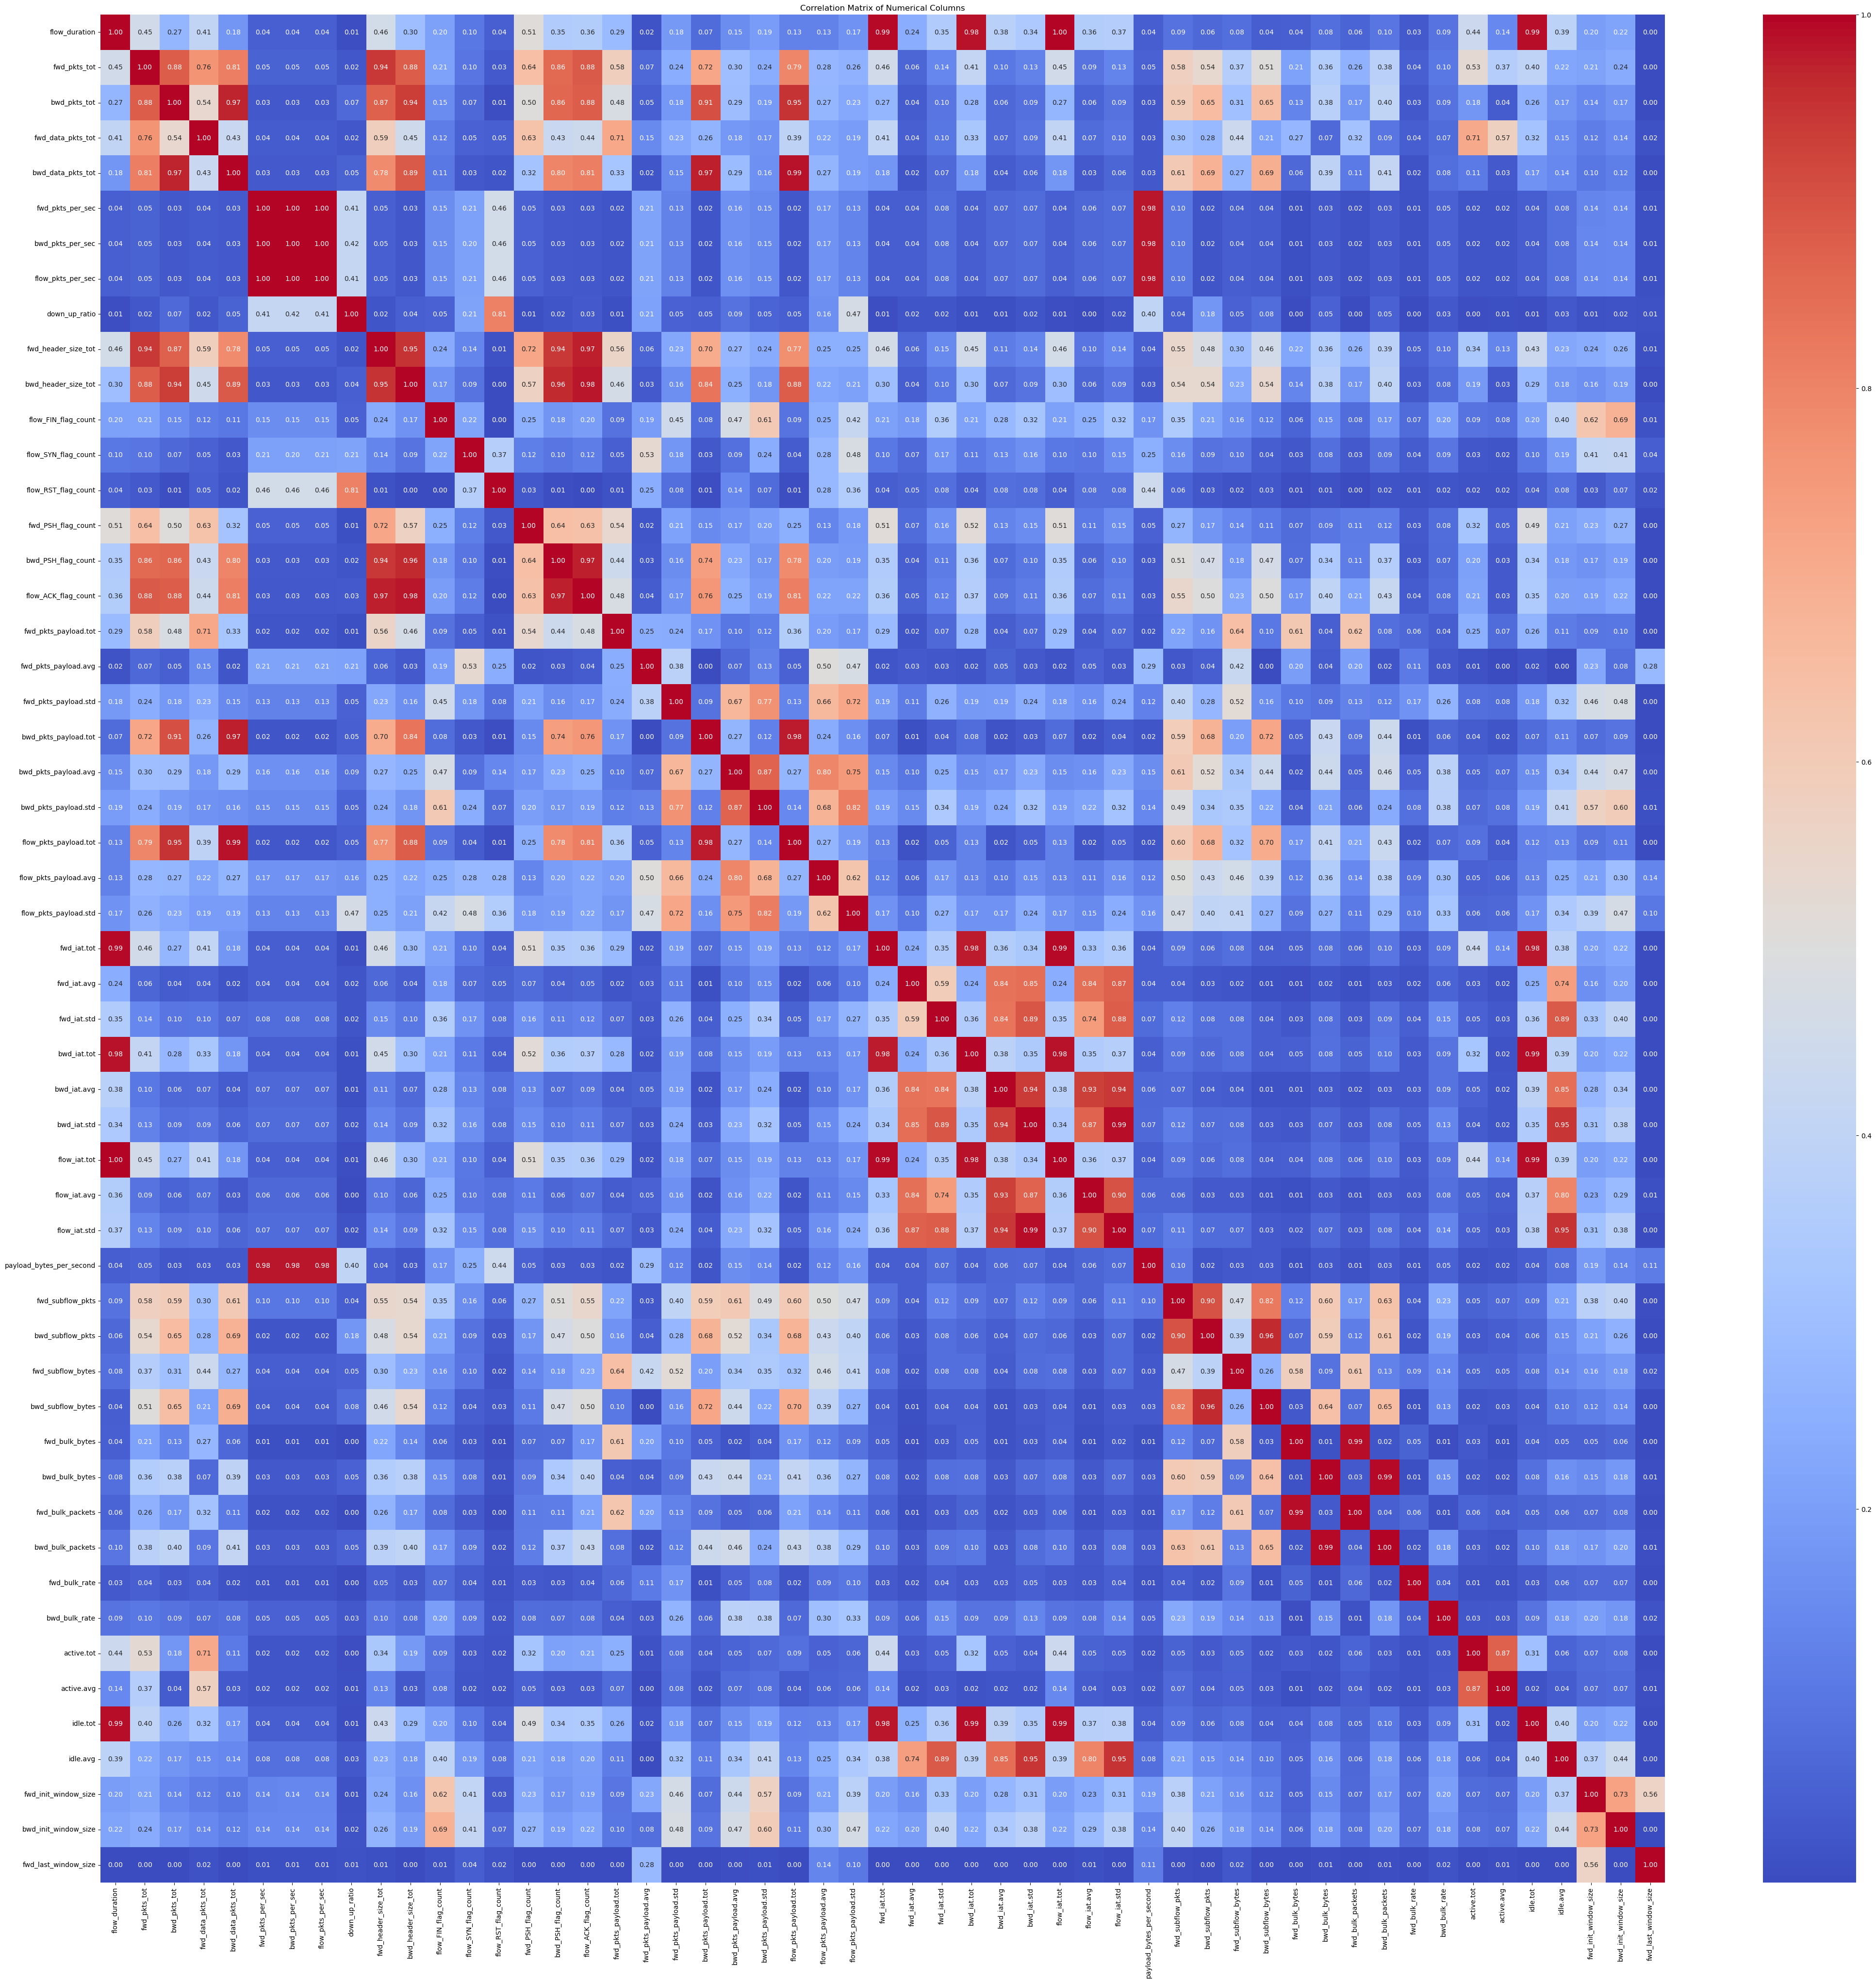

Dropping 18 highly correlated features:
['bwd_data_pkts_tot', 'bwd_pkts_per_sec', 'flow_pkts_per_sec', 'bwd_header_size_tot', 'bwd_PSH_flag_count', 'flow_ACK_flag_count', 'bwd_pkts_payload.tot', 'flow_pkts_payload.tot', 'fwd_iat.tot', 'bwd_iat.tot', 'flow_iat.tot', 'flow_iat.std', 'payload_bytes_per_second', 'bwd_subflow_bytes', 'fwd_bulk_packets', 'bwd_bulk_packets', 'idle.tot', 'idle.avg']


In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

# Compute correlation matrix on numeric columns
corr_matrix = df.drop('Attack_type', axis=1).corr().abs()

# Step 2: Plot correlation matrix
plt.figure(figsize=(52, 50))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Numerical Columns')
plt.show()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Find features with correlation > 0.95
to_drop_corr = [column for column in upper.columns if any(upper[column] > 0.95)]

print(f"Dropping {len(to_drop_corr)} highly correlated features:")
print(to_drop_corr)

# Drop them
df = df.drop(columns=to_drop_corr)

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 110610 entries, 99349 to 209958
Data columns (total 36 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   flow_duration          110610 non-null  float64
 1   fwd_pkts_tot           110610 non-null  int64  
 2   bwd_pkts_tot           110610 non-null  int64  
 3   fwd_data_pkts_tot      110610 non-null  int64  
 4   fwd_pkts_per_sec       110610 non-null  float64
 5   down_up_ratio          110610 non-null  float64
 6   fwd_header_size_tot    110610 non-null  int64  
 7   flow_FIN_flag_count    110610 non-null  int64  
 8   flow_SYN_flag_count    110610 non-null  int64  
 9   flow_RST_flag_count    110610 non-null  int64  
 10  fwd_PSH_flag_count     110610 non-null  int64  
 11  fwd_pkts_payload.tot   110610 non-null  float64
 12  fwd_pkts_payload.avg   110610 non-null  float64
 13  fwd_pkts_payload.std   110610 non-null  float64
 14  bwd_pkts_payload.avg   110610 non-nul

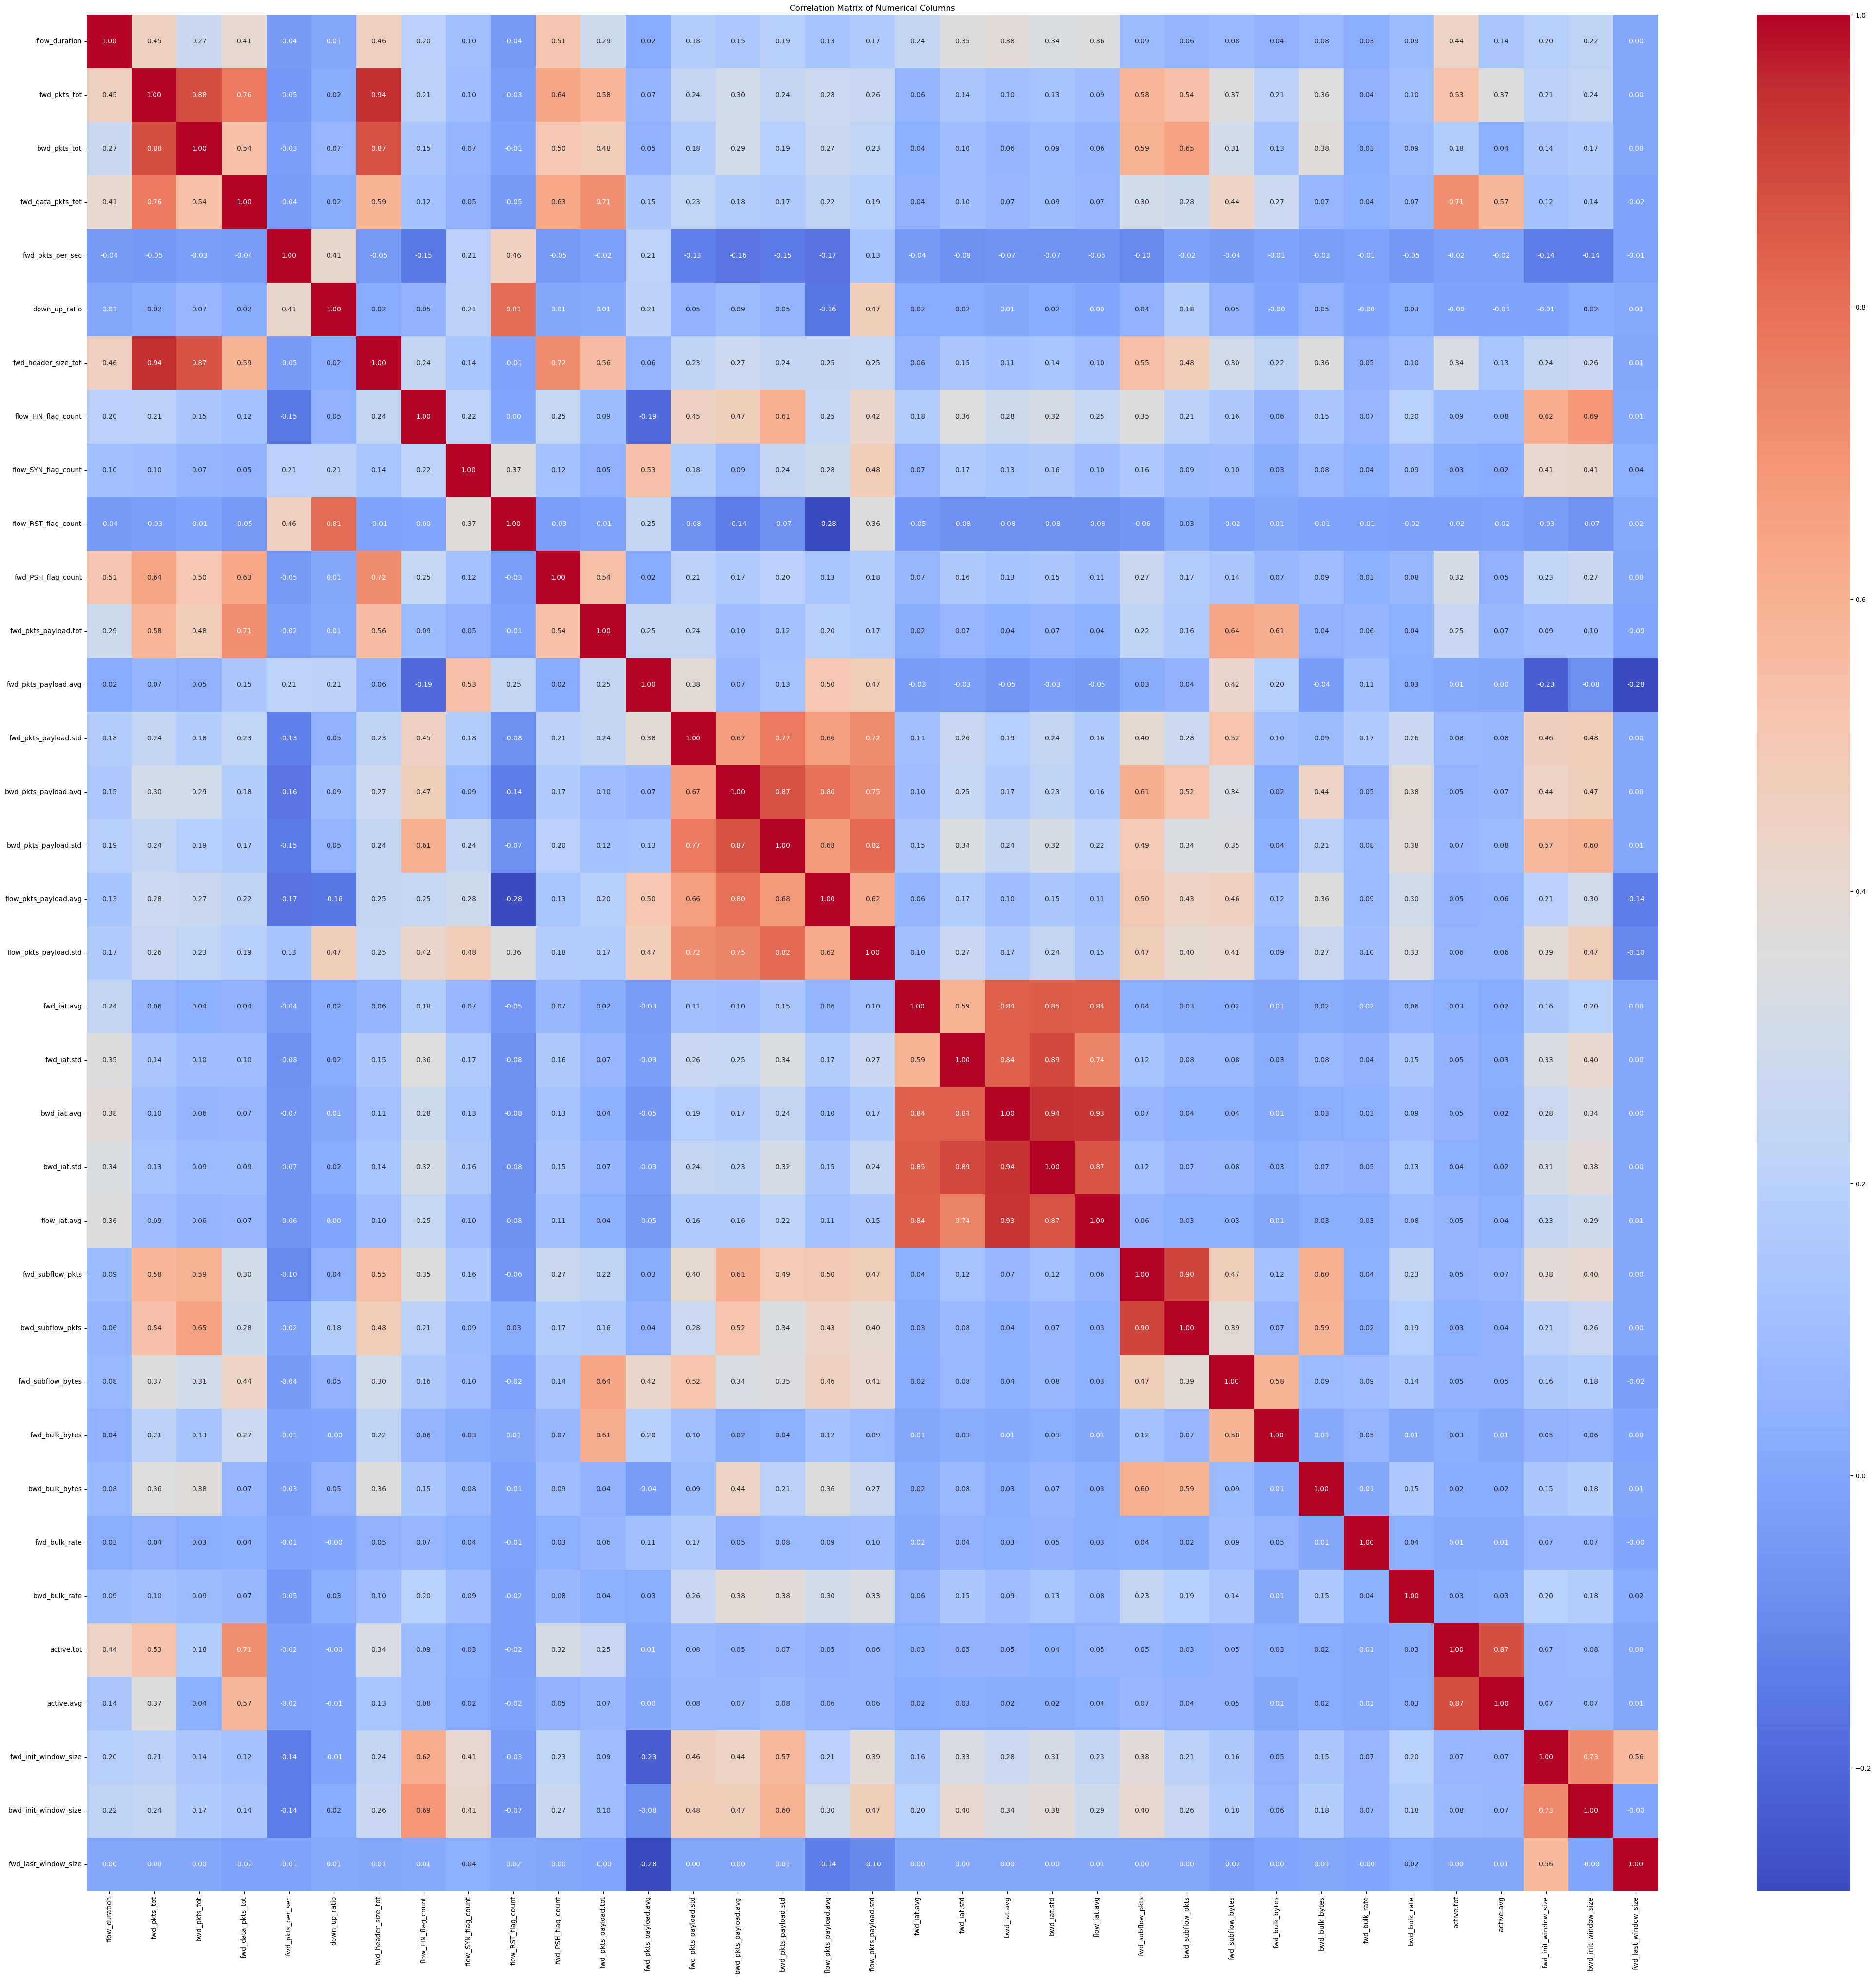

In [28]:
corr_matrix = df.corr(numeric_only=True)

# Step 2: Plot correlation matrix
plt.figure(figsize=(52, 50))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Numerical Columns')
plt.show()


In [30]:
# Merge the last 3 Attack_type values into one category
df['Attack_type'] = df['Attack_type'].replace({
    'DDOS_Slowloris': 'Other_Attacks',
    'Metasploit_Brute_Force_SSH': 'Other_Attacks',
    'NMAP_FIN_SCAN': 'Other_Attacks'
})

In [32]:
df['Attack_type'].value_counts()

Attack_type
DOS_SYN_Hping          94659
ARP_poisioning          7750
NMAP_UDP_SCAN           2590
NMAP_XMAS_TREE_SCAN     2010
NMAP_OS_DETECTION       2000
NMAP_TCP_scan           1002
Other_Attacks            599
Name: count, dtype: int64

In [34]:
# Step 1: Split 70% train and 30% (test + validation)
X_train, X_temp, y_train, y_temp = train_test_split(
    df.drop('Attack_type', axis=1),
    df['Attack_type'],
    test_size=0.3,  # 30% will be split into test and validation
    random_state=42,
    stratify=df['Attack_type']
)

# Step 2: Split the 30% temp into 20% test and 10% validation
X_val, X_test, y_val, y_test = train_test_split(
    X_temp,
    y_temp,
    test_size=2/3,  # 20% out of total, so test gets 2/3 of remaining 30%
    random_state=42,
    stratify=y_temp
)

print("Training set shape:", X_train.shape, y_train.shape)
print("Testing set shape:", X_test.shape, y_test.shape)
print("Validation set shape:", X_val.shape, y_val.shape)

Training set shape: (77427, 35) (77427,)
Testing set shape: (22122, 35) (22122,)
Validation set shape: (11061, 35) (11061,)


In [36]:
label_encoder = LabelEncoder()

# Encode target labels
y_train_enc = label_encoder.fit_transform(y_train)
y_val_enc = label_encoder.transform(y_val)
y_test_enc = label_encoder.transform(y_test)

***Base Model Fit***

In [39]:
from pytorch_tabnet.metrics import Metric

# Step 1: Define numeric preprocessing
numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features)
])

class F1Macro(Metric):
    def __init__(self):
        self._name = "F1Macro"
        self._maximize = True  # Set to False if lower is better

    def __call__(self, y_true, y_score):
        preds = np.argmax(y_score, axis=1)
        return f1_score(y_true, preds, average="macro")

tabnet = TabNetClassifier()
tabnet.fit(
    X_train=X_train.values, y_train=y_train.reset_index(drop=True).values,
    eval_set=[(X_val.values, y_val.reset_index(drop=True).values)],
    eval_metric=[F1Macro],
    max_epochs=200,
    patience=10,
    batch_size=1024,
    virtual_batch_size=128,
    num_workers=0
)

# Predict and convert probabilities to class labels
y_pred_train = tabnet.predict(X_train.values)

# Evaluate
macro_f1 = f1_score(y_train, y_pred_train, average='macro')
print(f"F1 Macro Score (Train): {macro_f1:.4f}")
print(classification_report(y_train, y_pred_train))

/opt/anaconda3/lib/python3.12/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.55087 | val_0_F1Macro: 0.29773 |  0:00:01s
epoch 1  | loss: 0.10616 | val_0_F1Macro: 0.53915 |  0:00:02s
epoch 2  | loss: 0.07496 | val_0_F1Macro: 0.79805 |  0:00:03s
epoch 3  | loss: 0.05723 | val_0_F1Macro: 0.83551 |  0:00:04s
epoch 4  | loss: 0.0483  | val_0_F1Macro: 0.89054 |  0:00:05s
epoch 5  | loss: 0.03978 | val_0_F1Macro: 0.8819  |  0:00:06s
epoch 6  | loss: 0.03777 | val_0_F1Macro: 0.89216 |  0:00:07s
epoch 7  | loss: 0.03749 | val_0_F1Macro: 0.89169 |  0:00:08s
epoch 8  | loss: 0.03754 | val_0_F1Macro: 0.84223 |  0:00:09s
epoch 9  | loss: 0.03601 | val_0_F1Macro: 0.89564 |  0:00:10s
epoch 10 | loss: 0.03384 | val_0_F1Macro: 0.88011 |  0:00:11s
epoch 11 | loss: 0.03161 | val_0_F1Macro: 0.89573 |  0:00:12s
epoch 12 | loss: 0.03186 | val_0_F1Macro: 0.89337 |  0:00:13s
epoch 13 | loss: 0.03091 | val_0_F1Macro: 0.88942 |  0:00:14s
epoch 14 | loss: 0.0306  | val_0_F1Macro: 0.90094 |  0:00:16s
epoch 15 | loss: 0.03269 | val_0_F1Macro: 0.90642 |  0:00:17s
epoch 16

/opt/anaconda3/lib/python3.12/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


F1 Macro Score (Train): 0.9111
                     precision    recall  f1-score   support

     ARP_poisioning       0.96      0.91      0.94      5425
      DOS_SYN_Hping       1.00      1.00      1.00     66261
  NMAP_OS_DETECTION       1.00      1.00      1.00      1400
      NMAP_TCP_scan       0.99      1.00      0.99       702
      NMAP_UDP_SCAN       0.78      0.98      0.87      1813
NMAP_XMAS_TREE_SCAN       1.00      0.99      1.00      1407
      Other_Attacks       0.81      0.46      0.59       419

           accuracy                           0.99     77427
          macro avg       0.93      0.91      0.91     77427
       weighted avg       0.99      0.99      0.99     77427



In [46]:
import optuna

# Custom F1 macro metric for TabNet
class F1Macro(Metric):
    def __init__(self):
        self._name = "F1Macro"
        self._maximize = True

    def __call__(self, y_true, y_score):
        preds = np.argmax(y_score, axis=1)
        return f1_score(y_true, preds, average="macro")

# Objective function to optimize based on validation set
def objective(trial):
    params = {
        "n_d": trial.suggest_categorical("n_d", [16, 25, 32, 64]),
        "n_a": trial.suggest_categorical("n_a", [16, 25, 32, 64]),
        "n_steps": trial.suggest_int("n_steps", 3, 7),
        "gamma": trial.suggest_float("gamma", 1.0, 2.0),
        "lambda_sparse": trial.suggest_float("lambda_sparse", 1e-4, 1e-1, log=True),
        "momentum": trial.suggest_float("momentum", 0.02, 0.4),
        "optimizer_params": dict(lr=trial.suggest_float("optimizer_lr", 1e-3, 0.1, log=True)),
        "mask_type": trial.suggest_categorical("mask_type", ["entmax", "sparsemax"]),
        "n_independent": trial.suggest_int("n_independent", 1, 3),
        "n_shared": trial.suggest_int("n_shared", 1, 3),
        "seed": 42
    }

    tabnet = TabNetClassifier(**params, verbose=0)

    # Train on TRAIN set only
    tabnet.fit(
        X_train=X_val.values,
        y_train=y_val.reset_index(drop=True).values,
        eval_metric=[F1Macro],
        max_epochs=200,
        patience=10,
        batch_size=1024,
        virtual_batch_size=128,
        num_workers=0
    )

    # Evaluate on VALIDATION set only
    y_pred_val = tabnet.predict(X_val.values)
    return f1_score(y_val, y_pred_val, average='macro')

# 🔁 Run Optuna
study = optuna.create_study(direction="maximize", study_name="tabnet_val_only")
study.optimize(objective, n_trials=30, timeout=1800)

# 🔎 Best result on validation
print("Best trial:")
print(f"  F1 Macro Score (Validation): {study.best_value:.4f}")
print("  Parameters:")
for k, v in study.best_params.items():
    print(f"    {k}: {v}")

[I 2025-07-06 14:38:28,633] A new study created in memory with name: tabnet_val_only
/opt/anaconda3/lib/python3.12/site-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)
[I 2025-07-06 14:39:43,449] Trial 0 finished with value: 0.9243275575663624 and parameters: {'n_d': 64, 'n_a': 16, 'n_steps': 5, 'gamma': 1.0682590410054096, 'lambda_sparse': 0.020741479770506922, 'momentum': 0.031821242531242876, 'optimizer_lr': 0.00993350482357494, 'mask_type': 'sparsemax', 'n_independent': 2, 'n_shared': 2}. Best is trial 0 with value: 0.9243275575663624.
/opt/anaconda3/lib/python3.12/site-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)
[I 2025-07-06 14:41:49,159] Trial 1 finished with value: 0.6917331446446455 and parameters: {'n_d': 64, 'n_a': 64, 'n_steps': 6, 'gamma': 1.14639681619

Best trial:
  F1 Macro Score (Validation): 0.9550
  Parameters:
    n_d: 32
    n_a: 64
    n_steps: 6
    gamma: 1.1402043036205307
    lambda_sparse: 0.0028170010247318615
    momentum: 0.10028345035948649
    optimizer_lr: 0.0424888105730515
    mask_type: entmax
    n_independent: 2
    n_shared: 1


In [48]:
# Extract best parameters
best_params = study.best_params

# Rebuild model with best params
tabnet_best = TabNetClassifier(
    n_d=best_params["n_d"],
    n_a=best_params["n_a"],
    n_steps=best_params["n_steps"],
    gamma=best_params["gamma"],
    lambda_sparse=best_params["lambda_sparse"],
    momentum=best_params["momentum"],
    optimizer_params={"lr": best_params["optimizer_lr"]},
    mask_type=best_params["mask_type"],
    n_independent=best_params["n_independent"],
    n_shared=best_params["n_shared"],
    seed=42,
    verbose=0
)

# Re-train on validation set only (as you did in tuning)
tabnet_best.fit(
    X_train=X_val.values,
    y_train=y_val.reset_index(drop=True).values,
    eval_metric=[F1Macro],
    max_epochs=200,
    patience=10,
    batch_size=1024,
    virtual_batch_size=128,
    num_workers=0
)

# Predict on the same validation set
y_pred_val = tabnet_best.predict(X_val.values)

# Print F1 Macro and classification report
val_f1 = f1_score(y_val, y_pred_val, average='macro')
print(f"\n🔍 Final Evaluation on Validation Set:")
print(f"F1 Macro Score (Validation): {val_f1:.4f}")
print("Classification Report (Validation):")
print(classification_report(y_val, y_pred_val))

/opt/anaconda3/lib/python3.12/site-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)



🔍 Final Evaluation on Validation Set:
F1 Macro Score (Validation): 0.9550
Classification Report (Validation):
                     precision    recall  f1-score   support

     ARP_poisioning       0.99      0.93      0.96       775
      DOS_SYN_Hping       1.00      1.00      1.00      9466
  NMAP_OS_DETECTION       1.00      1.00      1.00       200
      NMAP_TCP_scan       0.98      0.99      0.99       100
      NMAP_UDP_SCAN       0.81      0.97      0.88       259
NMAP_XMAS_TREE_SCAN       1.00      0.99      0.99       201
      Other_Attacks       0.96      0.78      0.86        60

           accuracy                           0.99     11061
          macro avg       0.96      0.95      0.95     11061
       weighted avg       0.99      0.99      0.99     11061



***Evaluate on Test Set***

In [49]:
# Predict and convert probabilities to class labels
y_pred_test = tabnet.predict(X_test.values)

# Evaluate
macro_f1 = f1_score(y_test, y_pred_test, average='macro')
print(f"F1 Macro Score (Test): {macro_f1:.4f}")
print(classification_report(y_test, y_pred_test))

F1 Macro Score (Test): 0.9106
                     precision    recall  f1-score   support

     ARP_poisioning       0.96      0.91      0.94      1550
      DOS_SYN_Hping       1.00      1.00      1.00     18932
  NMAP_OS_DETECTION       1.00      1.00      1.00       400
      NMAP_TCP_scan       1.00      0.99      1.00       200
      NMAP_UDP_SCAN       0.78      0.97      0.86       518
NMAP_XMAS_TREE_SCAN       1.00      0.99      0.99       402
      Other_Attacks       0.75      0.47      0.58       120

           accuracy                           0.99     22122
          macro avg       0.93      0.91      0.91     22122
       weighted avg       0.99      0.99      0.99     22122



In [52]:
tabnet_best.save_model("tabnet_best_model")

Successfully saved model at tabnet_best_model.zip


'tabnet_best_model.zip'